<a href="https://colab.research.google.com/github/nhut-ngnn/Practice-Graph_Neural_Network/blob/main/GNN_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install torch_geometric

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

data = pd.DataFrame({
    'feature1': [1, 2, 3, 4],
    'feature2': [4, 3, 2, 1],
    'feature3': [7, 8, 9, 6]
})

similarity_matrix = cosine_similarity(data)

G = nx.Graph()

for i in range(len(data)):
    G.add_node(i)

K = 2
for i in range(len(similarity_matrix)):
    top_k_nodes = np.argsort(similarity_matrix[i])[-(K+1):-1]
    for j in top_k_nodes:
        G.add_edge(i, j, weight=similarity_matrix[i][j])

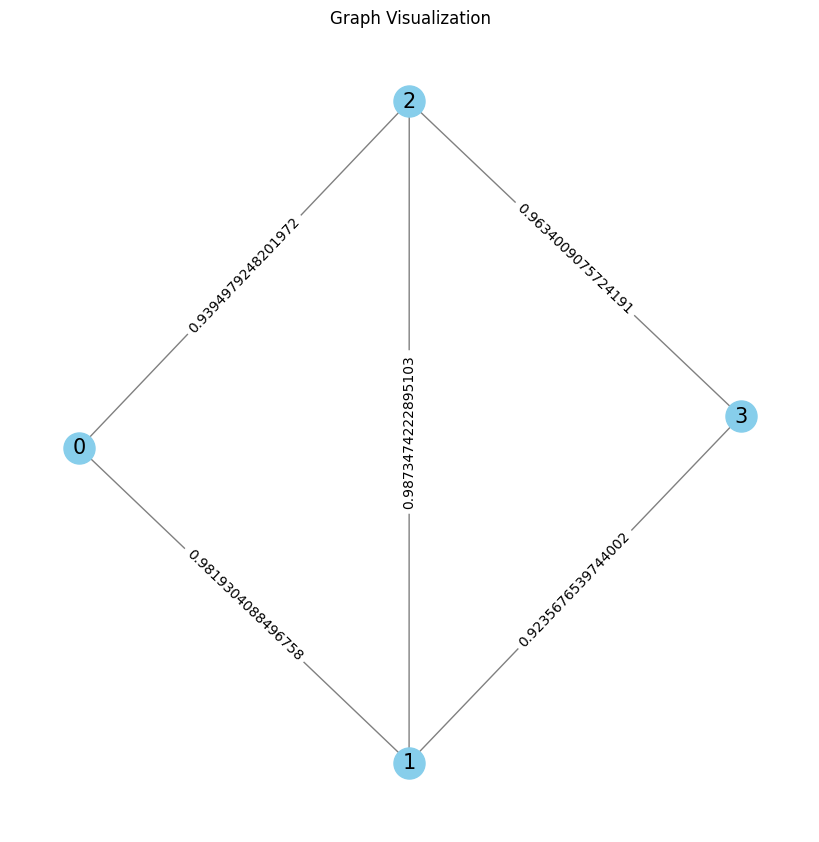

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.spring_layout(G)

plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=15)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Graph Visualization")
plt.show()


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import torch_geometric.transforms as T
from torch_geometric.utils import from_networkx

# Create a simple graph using NetworkX
X = torch.eye(G.number_of_nodes(), dtype=torch.float)

# Assume y is the node labels
y = torch.tensor([0, 1, 0, 1], dtype=torch.long)  # Example target labels

# Convert NetworkX graph to PyTorch Geometric data object
data = from_networkx(G)
data.x = X
data.y = y

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)  # Assuming 2 classes for classification

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and loss function
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.6985636949539185
Epoch 2, Loss: 0.6957822442054749
Epoch 3, Loss: 0.6936501264572144
Epoch 4, Loss: 0.6917155981063843
Epoch 5, Loss: 0.6898095607757568
Epoch 6, Loss: 0.6879647970199585
Epoch 7, Loss: 0.6861973404884338
Epoch 8, Loss: 0.6844395399093628
Epoch 9, Loss: 0.683226466178894
Epoch 10, Loss: 0.6821834444999695
Epoch 11, Loss: 0.6810853481292725
Epoch 12, Loss: 0.6799468398094177
Epoch 13, Loss: 0.6787625551223755
Epoch 14, Loss: 0.6775009632110596
Epoch 15, Loss: 0.6761941313743591
Epoch 16, Loss: 0.6748661994934082
Epoch 17, Loss: 0.6736765503883362
Epoch 18, Loss: 0.6722573637962341
Epoch 19, Loss: 0.6706885695457458
Epoch 20, Loss: 0.6690893173217773
Epoch 21, Loss: 0.6675058603286743
Epoch 22, Loss: 0.665881335735321
Epoch 23, Loss: 0.6642012596130371
Epoch 24, Loss: 0.6624467968940735
Epoch 25, Loss: 0.6606127619743347
Epoch 26, Loss: 0.658710777759552
Epoch 27, Loss: 0.6567586660385132
Epoch 28, Loss: 0.6547631025314331
Epoch 29, Loss: 0.65278649330139

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

model.eval()

with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)

accuracy = accuracy_score(data.y.cpu(), pred.cpu())
precision = precision_score(data.y.cpu(), pred.cpu(), average='macro')
recall = recall_score(data.y.cpu(), pred.cpu(), average='macro')
f1 = f1_score(data.y.cpu(), pred.cpu(), average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.7500
Precision: 0.8333
Recall: 0.7500
F1-Score: 0.7333
